In [1]:
import numpy as np
import copy
from scipy.signal import argrelextrema
from skimage.feature import peak_local_max

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import FormatStrFormatter

In [3]:
#CODATA 2017
kB = 1.38064903E-23  #J/K
Na = 6.022140758E+23 #1/mol

In [4]:
#Necessary Packages
#import numpy as np
#import copy
#from scipy.signal import argrelextrema

class FHMC_Analysis:
    def __init__(self,lnZ0,V,beta,Debug=False,Extrapolated=False):
        self.N = np.array([])
        self.lnPi = np.array([])
        self.energy = np.array([])
        self.energy2 = np.array([])
        self.lnZ0 = lnZ0
        self.V = V
        self.beta = beta
        self.Debug = Debug
        self.Extrapolated = Extrapolated
    def CheckTail_func(self,threshold):
        #maxima = argrelextrema( self.lnPi, np.greater )
        maxima = peak_local_max( self.lnPi )[0]
        delta = np.abs(self.lnPi[int(maxima[-1])] - self.lnPi[-1])
        if delta < threshold:
            return False
        else:
            return True    
    def reweight(self,lnZ_rw, Normalize=False, Output=False, CheckTail=False):
        # Reweighting operation
        lnPi_temp = self.lnPi + self.N*(lnZ_rw-self.lnZ0)
        # Shift relative to max value
        lnPi_temp = lnPi_temp - max(lnPi_temp)
        # Normalize, if desired
        if Normalize: lnPi_temp = lnPi_temp - np.log( np.sum( np.exp(lnPi_temp) ) )
        # Create a child object and replace the lnPi and lnZ
        child = copy.deepcopy(self) # double ensure that the child is a new object, not a pointer
        child.lnZ0 = lnZ_rw
        child.lnPi = np.array(lnPi_temp)
        # Check the tail of the distribution
        if CheckTail:
            if not child.CheckTail_func(threshold=10.0):
                raise Exception('\nReweighted to lnZ = '+str(lnZ_rw)+'\n' \
                                'Insufficient Tail \n')

        return child
    def temperature_extrapolate(self,beta_extrap, order=1, Normalize=False, CheckTail=False):
        if self.Extrapolated:
            raise Exception('\nNO NO NO\nDo not extrapolate already-extrapolated lnPi!')
        mu = self.lnZ0/self.beta
        if order < 1:
            raise Exception('\nExtrapolation Order = '+str(order)+' not possible\n' \
                                'Check your input data')
        #First Order Extrapolation
        lnPi_temp = self.lnPi + (beta_extrap - self.beta)*(mu*self.N - self.energy)
        #NOTE: Inconsequential terms were skipped; they are all independent of N
        #      and so do not affect the relative values of Pi
        if order == 2:
            #Second Order Extrapolation            
            lnPi_temp = lnPi_temp + 0.50 * ((beta_extrap - self.beta)**2)*(self.energy2 - (self.energy)**2)
            #NOTE: As for first order extrap, inconsequential terms were skipped
        if order > 2:
            raise Exception('\nExtrapolation Order = '+str(order)+' not possible\n' \
                                'Check your input data')
        #Normalize, if desired
        if Normalize: lnPi_temp = lnPi_temp - np.log( np.sum( np.exp(lnPi_temp) ) )
        # Create a child object and replace the lnPi, lnZ and beta
        child = copy.deepcopy(self) # double ensure that the child is a new object, not a pointer
        child.beta = beta_extrap
        child.lnZ0 = self.lnZ0*beta_extrap/self.beta
        child.lnPi = lnPi_temp
        child.Extrapolated = True
        # Check the tail of the distribution
        if CheckTail:
            if not child.CheckTail_func(threshold=10.0):
                raise Exception('\nExtrapolated to beta = '+str(beta_extrap)+'\n' \
                                'Insufficient Tail')
        return child
    def phase_boundaries(self):
        #maxima = argrelextrema( self.lnPi, np.greater, order=10 )
        maxima = peak_local_max( self.lnPi )[0]
        if len(maxima) == 1:
            Nbound = self.N[-1]
            phases = 1
        elif ln(maxima) == 2:
            #minima = argrelextrema( self.lnPi, np.less, order=10 )
            minima = peak_local_max( -self.lnPi )[0]
            Nbound = int(minima[0])
            phases = 2
        else:
            raise Exception('\nMore than two maxima in lnPi\n'+\
                            'Current lnZ = '+str(self.lnZ))                       
        return phases, Nbound

    #Function for computing ensemble properties
    def ensemble_properties(self):
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        Navg = np.dot( self.N, Pi )/denom
        N2avg = np.dot( (self.N)**2, Pi )/denom
        Uavg = np.dot( self.energy, Pi )/denom
        U2avg = np.dot( self.energy2, Pi )/denom
        UNavg = np.dot( np.multiply(self.N,self.energy), Pi )/denom
        #Determine a better way to output all of these moments
        return Navg,N2avg,Uavg,U2avg,UNavg
    
    #Function for computing phase properties
    def phase_properties(self):
        # Phase-specific properties
        phases, Nbound = self.phase_boundaries()
        #Create lists for properties computation
        Navg = [ [0. for x in range(phases)] for i in range(2) ]
        Uavg = [0. for x in range(phases)]
        UNavg = [0. for x in range(phases)]
        for i in range(phases):
            #NOTE: the "numpy.multiply" function is the "Hadamard" Product,
            # e.g., element-wise multiplication of two tensors of the same rank;
            # it yields a tensor of the same rank as the input tensors
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                denom = np.sum( Pi[:Nbound] )
                for j in range(2):
                    Navg[j][i] = np.dot( self.N[:Nbound]**(j+1), Pi[:Nbound] )/denom
                Uavg[i] = np.dot( self.energy[:Nbound], Pi[:Nbound] )/denom
                UNavg[i] = np.dot( np.multiply(self.N[:Nbound],self.energy[:Nbound]),Pi[:Nbound] )/denom
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                denom = np.sum( Pi[Nbound+1:] )
                for j in range(2):
                    Navg[i] = np.dot( self.N[Nbound+1:]**(j+1), Pi[Nbound+1:] )/denom
                Uavg[i] = np.dot( self.energy[Nbound+1:], Pi[Nbound+1:] )/denom
                UNavg[i] = np.dot( np.multiply(self.N[Nbound+1:],self.energy[Nbound+1:]),Pi[Nbound+1:] )/denom            
        return Navg,Uavg,UNavg

    def grand_potential(self):
        # Phase-specific properties
        phases, Nbound = self.phase_boundaries()
        # Create list
        Omega = [0. for x in range(phases)]
        for i in range(phases):
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                Omega[i]=(np.log(Pi[0]) - np.log(np.sum(Pi[:Nbound])))/self.beta
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                Omega[i]=(np.log(Pi[0]) - np.log(np.sum(Pi[Nbound+1:])))/self.beta
        return Omega

    def pressure(self):
        return [-x/self.V for x in self.grand_potential()]

    def canonical_entropy_ex(self):
        Sx = self.lnPi - self.lnPi[0] + self.beta*self.energy - self.lnZ0*self.N
        return np.array(Sx)

    def grandcanonical_entropy_ex(self):
        Sx = self.canonical_entropy_ex()
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        Sx_gc = np.dot( Sx, Pi )/denom
        return Sx_gc
    
    def grandcanonical_entropy_ex_phases(self):
        Sx = self.canonical_entropy_ex()
        phases, Nbound = self.phase_boundaries()
        #Create lists for properties computation
        Sx_gc = [0. for x in range(phases)]
        for i in range(phases):
            #NOTE: the "numpy.multiply" function is the "Hadamard" Product,
            # e.g., element-wise multiplication of two tensors of the same rank;
            # it yields a tensor of the same rank as the input tensors
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                denom = np.sum( Pi[:Nbound] )
                Sx_gc[i] = np.dot( Sx[:Nbound], Pi[:Nbound] )/denom
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                denom = np.sum( Pi[Nbound+1:] )
                Sx_gc[i] = np.dot( Sx[Nbound+1:], Pi[Nbound+1:] )/denom
        return Sx_gc

In [5]:
# Data Abstraction [this is code-specific]
src = '/mnt/WS_PN107151/dsideriu/Research/Monte_Carlo/my_FEASST/MFI_Argon/MFI_Argon_LJLFS'
MC_output = 'colMat'

with open(src+'/'+MC_output,mode='r') as f:
    text_in = f.readlines()

    
for (lineID,line) in enumerate(text_in):
    if (line.split()[1] == 'lnz'):
        lnZ = float(line.split()[2])
    elif (line.split()[1] == 'beta'):
        beta = float(line.split()[2])
        T = 1./beta
    #print(line.strip('\n'))
    elif ("macrostate" in line.split()[1]): #macrostate data is after this
        macro_data = text_in[(lineID+1):]
        
#SEEMS LIKE THERE SHOULD BE A BETTER WAY TO DO THIS...
#  WHY DO I NEED TO CREATE PYTHON LISTS, THEN CONVERT THEM TO NumPy ARRAYS?
N = np.array( [ int(x.split()[0]) for x in macro_data ] )
lnPi = np.array( [ float(x.split()[1]) for x in macro_data ] )
#energy = np.array( [ float(x.split()[2]) for x in macro_data ] )
energy = np.array( [ float(x.split()[9])/float(x.split()[8]) for x in macro_data ] )
energy = energy - energy[0]
energy2 = np.array( [ float(x.split()[10])/float(x.split()[8]) for x in macro_data ] )


# Instantiate the confined fluid data object
confined = FHMC_Analysis(lnZ,1.,beta)
confined.N = N
confined.lnPi = lnPi
confined.energy = energy
confined.energy2 = energy2
#print(confined.beta)

#for lnZ_rw in np.linspace(beta*-20., beta*-0.75,10):
#    new = confined.reweight(lnZ_rw,CheckTail=True)
#    Sx = new.grandcanonical_entropy_ex_phases()
#    Nav = new.phase_properties()[0]
#    #print(lnZ_rw, Sx, Nav[0])
#    print(lnZ_rw, Sx[0]/Nav[0][0])

In [6]:
# Data Abstraction [this is code-specific]
src = '/mnt/WS_PN107151/dsideriu/Research/Monte_Carlo/my_FEASST/MFI_Argon/bulk_LJLFS'
MC_output = 'colMat'

with open(src+'/'+MC_output,mode='r') as f:
    text_in = f.readlines()

    
for (lineID,line) in enumerate(text_in):
    if (line.split()[1] == 'lnz'):
        lnZ = float(line.split()[2])
    elif (line.split()[1] == 'beta'):
        beta = float(line.split()[2])
        T = 1./beta
    #print(line.strip('\n'))
    elif ("macrostate" in line.split()[1]): #macrostate data is after this
        macro_data = text_in[(lineID+1):]

#SEEMS LIKE THERE SHOULD BE A BETTER WAY TO DO THIS...
#  WHY DO I NEED TO CREATE PYTHON LISTS, THEN CONVERT THEM TO NumPy ARRAYS?
N = np.array( [ int(x.split()[0]) for x in macro_data ] )
lnPi = np.array( [ float(x.split()[1]) for x in macro_data ] )
#energy = np.array( [ float(x.split()[2]) for x in macro_data ] )
energy = np.array( [ float(x.split()[9])/float(x.split()[8]) for x in macro_data ] )
energy = energy - energy[0]
energy2 = np.array( [ float(x.split()[10])/float(x.split()[8]) for x in macro_data ] )

#Convert the activity and temperature
sigma_LJ = 3.405 #Angstroms
eps_LJ = 119.80 #K
lnZ = lnZ - 3.*np.log(sigma_LJ)
beta = beta/eps_LJ/kB/Na * 1.e3
energy = energy * eps_LJ * kB * Na / 1.e3

V = 30.**3 #Angstroms^3

# Instantiate the confined fluid data object
bulk = FHMC_Analysis(lnZ,V,beta)
bulk.N = N
bulk.lnPi = lnPi
bulk.energy = energy
bulk.energy2 = energy2

#for lnZ_rw in np.linspace(beta*-20., beta*-1.1,10):
#    new = bulk.reweight(lnZ_rw,CheckTail=True)
#    #new = bulk.reweight(lnZ_rw,CheckTail=False)
#    Sx = new.grandcanonical_entropy_ex_phases()
#    Nav = new.phase_properties()[0]
#    print(lnZ_rw, Sx, Nav[0])
#    #print(lnZ_rw, Sx[0]/Nav[0][0])

In [7]:
print(bulk.lnZ0, confined.lnZ0)

-6.675734818804427 -3.0


In [8]:
#Adsorption Isotherm

mus = np.linspace(-6.4-3.*np.log(sigma_LJ), 0.4-3.*np.log(sigma_LJ), 50)
for lnZ_rw in mus:
    new = bulk.reweight(lnZ_rw,Normalize=True)
    p = new.pressure()[0]
    #print(new.lnPi[0]/new.beta, new.grand_potential())
    new = confined.reweight(lnZ_rw,CheckTail=True)
    print(lnZ_rw+3.*np.log(sigma_LJ), p, new.phase_properties()[0][0][0])

-6.4 0.00010478954370984889 12.414621150646779
-6.261224489795918 0.0001204167585125032 14.181443883405134
-6.122448979591837 0.00013837943686106205 16.19732204032095
-5.983673469387755 0.00015902815168040356 18.435243774570512
-5.844897959183674 0.00018276644968739556 20.84446913343088
-5.706122448979592 0.00021005882136044426 23.40851425375209
-5.5673469387755095 0.00024143976584867704 26.188357664466523
-5.428571428571429 0.00027752404943574556 29.32762667187484
-5.289795918367346 0.0003190182887836736 32.989197240663884
-5.151020408163266 0.00036673409500704126 37.173372954754264
-5.012244897959183 0.00042160324115783306 41.66939243869271
-4.873469387755103 0.0004846956736593808 46.28217778890893
-4.73469387755102 0.000557241553939569 51.02264573204532
-4.595918367346938 0.0006406585588379113 56.164038693931815
-4.457142857142857 0.0007365850227540803 61.97812698219737
-4.318367346938775 0.000846918463069509 68.27627642167495
-4.179591836734694 0.0009738592507645044 74.647058117707

In [9]:
mus = np.linspace(-6.4-3.*np.log(sigma_LJ), 0.4-3.*np.log(sigma_LJ), 50)
print(mus[0], mus[-1])

-10.075734818804428 -3.2757348188044273


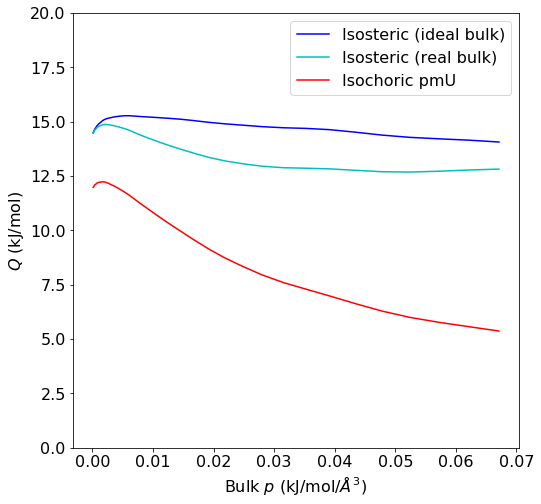

In [10]:
# Isosteric Heat Calculations

mus = np.linspace(-6.4-3.*np.log(sigma_LJ), 0.4-3.*np.log(sigma_LJ), 50)
Q_trad = []
Q_isochoric = []
Q_proper = []
pressure = []

for lnZ_rw in mus:
    #Bulk Phase
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    props_bulk = new.phase_properties()
    pressure.append( new.pressure()[0]  )
    Nav_b = props_bulk[0][0][0]
    Uav_b = props_bulk[1][0]
    fUN_b = (props_bulk[2][0] - props_bulk[1][0]*props_bulk[0][0][0])
    fNN_b = (props_bulk[0][1][0]-props_bulk[0][0][0]**2)
    
    #Confined Phase
    new = confined.reweight(lnZ_rw,CheckTail=True)
    props_confined = new.phase_properties()
    Nav_c = props_confined[0][0][0]
    fUN_c = (props_confined[2][0] - props_confined[1][0]*props_confined[0][0][0])
    fNN_c = (props_confined[0][1][0]-props_confined[0][0][0]**2)
        
    Q_trad.append( 1/bulk.beta - fUN_c/fNN_c )
    Q_isochoric.append( fUN_b/fNN_b - fUN_c/fNN_c )
    Q_proper.append( (Uav_b + pressure[-1]*bulk.V)/Nav_b  - fUN_c/fNN_c  )
    
    #print(lnZ_rw,pressure[-1])
    #print(Q_trad[-1])
    #print(Q_proper[-1])
    #print(Q_isochoric[-1])

    
Q_trad = np.array(Q_trad)
Q_isochoric = np.array(Q_isochoric)
Q_proper = np.array(Q_proper)
    
fig = plt.figure(figsize=(8,8))
plt.plot(pressure, Q_trad, 'b', label="Isosteric (ideal bulk)")
plt.plot(pressure, Q_proper, 'c', label="Isosteric (real bulk)")
plt.plot(pressure, Q_isochoric, 'r', label="Isochoric pmU")
plt.gca().set_ylim(0,20.0)
plt.legend()
plt.xlabel(r'Bulk $p$ (kJ/mol/$\AA^3$)')
plt.ylabel(r'$Q$ (kJ/mol)')
plt.show()


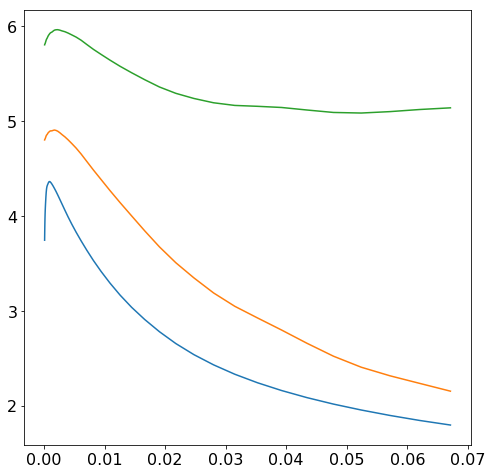

In [13]:
# Change in molar entropy [equivalent to the change in partial molar entropy]

mus = np.linspace(-6.4-3.*np.log(sigma_LJ), 0.4-3.*np.log(sigma_LJ), 50)
delta_molar_S = []
delta_isochoric_S = []
delta_isosteric_S = []
delta_S = []
pressure = []

for lnZ_rw in mus:
    #Bulk Phase
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    Sx = new.grandcanonical_entropy_ex_phases()
    props = new.phase_properties()
    molar_S_b = Sx[0]/props[0][0][0]
    isochoric_pmS_b = bulk.beta*(props[2][0]-props[1][0]*props[0][0][0])/(props[0][1][0] -props[0][0][0]**2) - new.lnZ0
    pressure.append( new.pressure()[0]  )
    pmH = (props[1][0] + pressure[-1]*bulk.V)/props[0][0][0]
    #Sbulk = ( props[1][0] - lnZ_rw*props[0][0][0]/new.beta -new.grand_potential()[0] )/props[0][0][0]*new.beta
        
    #Confined Phase
    new = confined.reweight(lnZ_rw,CheckTail=True)
    Sx = new.grandcanonical_entropy_ex_phases()
    props = new.phase_properties()
    molar_S_c = Sx[0]/props[0][0][0]
    isochoric_pmS_c = confined.beta*(props[2][0]-props[1][0]*props[0][0][0])/(props[0][1][0] -props[0][0][0]**2) - new.lnZ0
    fUN_c = props[2][0]-props[1][0]*props[0][0][0]
    fNN_c = props[0][1][0]-props[0][0][0]**2
    #Sconfined = ( props[1][0] - lnZ_rw*props[0][0][0]/new.beta -new.grand_potential()[0] )/props[0][0][0]*new.beta
    
    #Bulk - Confined
    delta_molar_S.append(molar_S_b - molar_S_c)
    #delta_S.append( Sbulk - Sconfined )
    delta_isochoric_S.append(isochoric_pmS_b-isochoric_pmS_c)
    delta_isosteric_S.append( (pmH -fUN_c/fNN_c)*new.beta )

    #print(Sbulk, Sconfined)
    #print(lnZ_rw, molar_S_b-molar_S_c)

delta_molar_S = np.array(delta_molar_S)
delta_S = np.array(delta_S)
delta_isochoric_S = np.array(delta_isochoric_S)
delta_isosteric_S = np.array(delta_isosteric_S)
    
fig = plt.figure(figsize=(8,8))
plt.plot(pressure, delta_molar_S, label = 'Delta Molar S (1)')
#plt.plot(pressure, delta_S, label = 'Delta Molar S (2)')
plt.plot(pressure, delta_isochoric_S,  label = 'Isochoric pmS')
plt.plot(pressure, delta_isosteric_S, label = 'Isosteric (real bulk)')
plt.plot()
plt.show()

In [14]:
print(delta_isosteric_S[0:10])

[5.80291465 5.80693298 5.80998993 5.8122694  5.81507331 5.81982205
 5.82647184 5.83425287 5.84333747 5.85337068]
